In [2]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from libs.simulation_tools import *
from qiskit_aer import AerSimulator
from libs.satellite import *

In [4]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
year = 2021
day = 357
hour = 16
minute = 29
t = np.arange(0, 241, 10)
second = 53 + t
utc = 9
latitude = location[:, 0]
longitude = location[:, 1]
elevation = location[:, 2]

slant_path_lst = np.zeros(len(second))
zenith_angle_lst = np.zeros(len(second))
for idx in range(len(second)):
    slant_path_lst[idx], zenith_angle_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude[idx], latitude[idx], elevation[idx]
    )

slant_path_lst = slant_path_lst * 1000

In [ ]:
num_channel_coefficients = 100 #100000
num_qubits_per_channel_coefficient = int(1e4)

tau_zen_lst = np.array([0.81, 0.75, 0.55])

In [ ]:
backend = AerSimulator()
user0 = User("Alice", None, None, None) 
user1 = User("Bob", None, None, None)

qber_simul =  np.zeros((len(tau_zen_lst), len(zenith_angle_lst)))

In [ ]:
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_lst)):
        zenith_angle_deg = zenith_angle_lst[jdx]
        zenith_angle_rad = np.radians(zenith_angle_deg)
        
        sigma_R_squared = rytov_variance(
            wavelength, zenith_angle_rad, h_OGS, h_atm, Cn2_profile)
        
        slant_distance = slant_path_lst[jdx]
        
        w_L = slant_path_lst[jdx] * theta_rad
        
        w_Leq_squared = equivalent_beam_width_squared(a, w_L)

        total_err_num = 0

        total_sifted_bit_length = 0

        for kdx in range(num_channel_coefficients):
            # print(kdx)
            eta_ell = compute_atm_loss(tau_zen, zenith_angle_rad)
            I_a = rvs_LN_fading(sigma_R_squared, size=1)
            eta_p = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_distance, theta_rad, a, w_Leq_squared, size=1
                )
            
            insta_eta = eta_ell * I_a * eta_p
            insta_qber = qber_loss(
                e_0, p_dark, e_pol, p_AP, insta_eta, n_s
            )[0]

            insta_yield = compute_yield(
                insta_eta, n_s, p_dark, p_AP
            )[0]
            
            # num_detected_event = int(insta_yield * num_qubits_per_channel_coefficient)
            num_detected_event = np.count_nonzero(
                np.random.choice([1, 0], p=[insta_yield, 1 - insta_yield], size=num_qubits_per_channel_coefficient))
            if (num_detected_event == 0):
                num_detected_event = 1

            part_ka, part_kb, err_num = generate_Siftedkey(
                user0, user1, num_detected_event, insta_qber, backend
            )
            
            total_err_num += err_num
            total_sifted_bit_length += len(part_ka)
        
        avg_qber = total_err_num/total_sifted_bit_length
        print(f'QBER: {avg_qber} at {zenith_angle_deg} deg',)
        qber_simul[idx][jdx] = avg_qber

QBER: 0.031624014790308456 at 59.89411598084398 deg
QBER: 0.029114033569821767 at 57.22489280234321 deg


KeyboardInterrupt: 

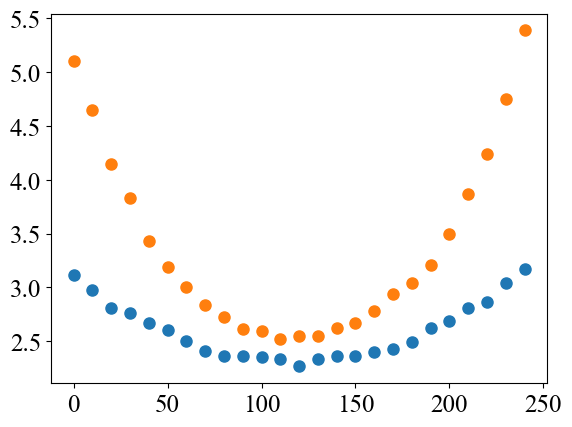

In [ ]:
plt.scatter(t, qber_simul[0][:]*100)
plt.scatter(t, qber_simul[1][:]*100)

In [10]:
skr_values =  np.zeros((len(tau_zen_lst), len(zenith_angle_lst)))

In [ ]:
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_lst)):
        zenith_angle_deg = zenith_angle_lst[jdx]
        zenith_angle_rad = np.radians(zenith_angle_deg)
        
        w_L = slant_path_lst[jdx] * theta_rad

        _, yield_values= compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
            zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )

        Q_1, e_1 = compute_Q_1_e_1_ex(
            sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
            zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )

        skr_values[idx][jdx] = compute_SKR(
            qber_simul[idx][jdx], yield_values, Q_1, e_1
        )

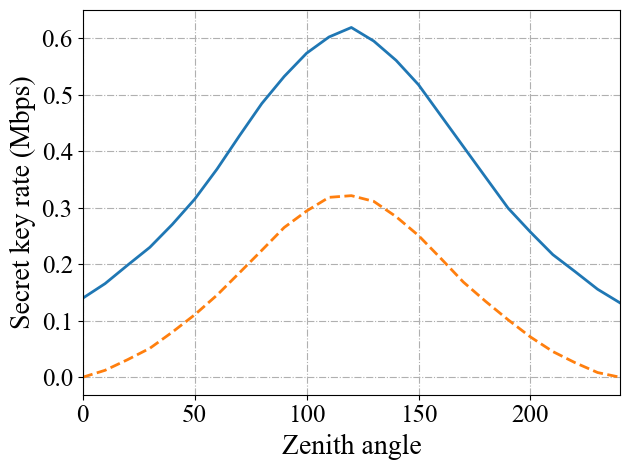

In [12]:
plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()

In [ ]:
np.save('results/qber_simul', qber_simul)

In [ ]:
np.save('results/skr_simul', skr_values)